Copyright (c) 2019 [Sebastian Raschka](sebastianraschka.com)

https://github.com/rasbt/python-machine-learning-book-3rd-edition

[MIT License](https://github.com/rasbt/python-machine-learning-book-3rd-edition/blob/master/LICENSE.txt)

# Rozdział 14. Czas na szczegóły — mechanizm działania biblioteki TensorFlow (2/3)

Zwróć uwagę, że rozszerzenie zawierające nieobowiązkowy znak wodny stanowi niewielki plugin notatnika IPython / Jupyter, który zaprojektowałem w celu powielania kodu źródłowego. Wystarczy pominąć poniższe wiersze kodu:

In [1]:
%load_ext watermark
%watermark -a "Sebastian Raschka & Vahid Mirjalili" -u -d -p numpy,scipy,matplotlib,tensorflow

Sebastian Raschka & Vahid Mirjalili 
last updated: 2019-11-03 

numpy 1.17.3
scipy 1.3.1
matplotlib 3.1.1
tensorflow 2.0.0


In [2]:
import numpy as np
import tensorflow as tf
import pandas as pd

from IPython.display import Image


## Estymatory TensorFlow

##### Etapy korzystania z gotowych estymatorów

 * **Etap 1.** Zdefiniuj funkcję wejściową importującą dane   
 * **Etap 2.** Zdefiniuje kolumny cech łączące estymator z danymi   
 * **etap 3.** Utwórz wystąpienie estymatora lub przekształć model Keras w estymator   
 * **Etap 4.** Użyj estymatora: train() - evaluate() - predict()   

In [3]:
tf.random.set_seed(1)
np.random.seed(1)

### Praca z kolumnami cech


 * Definicja: https://developers.google.com/machine-learning/glossary/#feature_columns
 * Dokumentacja: https://www.tensorflow.org/api_docs/python/tf/feature_column

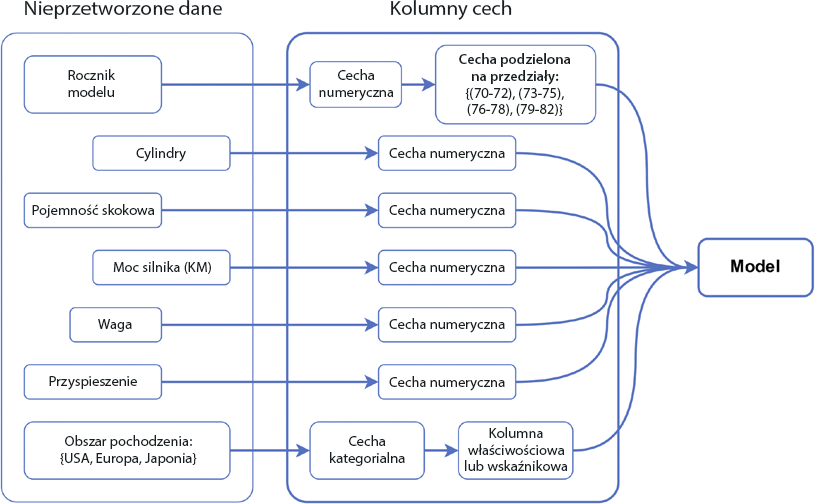

In [3]:
Image(filename='rysunki/02.png', width=700)

In [5]:
dataset_path = tf.keras.utils.get_file("auto-mpg.data", 
                                       ("http://archive.ics.uci.edu/ml/machine-learning-databases"
                                        "/auto-mpg/auto-mpg.data"))

column_names = ['Spalanie', 'Cylindry', 'Poj_skokowa', 'Moc',
                'Waga', 'Przyspieszenie', 'Rocznik_modelu', 'Obszar_pochodzenia']

df = pd.read_csv(dataset_path, names=column_names,
                 na_values = "?", comment='\t',
                 sep=" ", skipinitialspace=True)

df.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,ModelYear,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [6]:
print(df.isna().sum())

df = df.dropna()
df = df.reset_index(drop=True)
df.tail()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
ModelYear       0
Origin          0
dtype: int64


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,ModelYear,Origin
387,27.0,4,140.0,86.0,2790.0,15.6,82,1
388,44.0,4,97.0,52.0,2130.0,24.6,82,2
389,32.0,4,135.0,84.0,2295.0,11.6,82,1
390,28.0,4,120.0,79.0,2625.0,18.6,82,1
391,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [7]:
import sklearn
import sklearn.model_selection


df_train, df_test = sklearn.model_selection.train_test_split(df, train_size=0.8)
train_stats = df_train.describe().transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
MPG,313.0,23.404153,7.666909,9.0,17.5,23.0,29.0,46.6
Cylinders,313.0,5.402556,1.701506,3.0,4.0,4.0,8.0,8.0
Displacement,313.0,189.512780,102.675646,68.0,104.0,140.0,260.0,455.0
Horsepower,313.0,102.929712,37.919046,46.0,75.0,92.0,120.0,230.0
Weight,313.0,2961.198083,848.602146,1613.0,2219.0,2755.0,3574.0,5140.0
Acceleration,313.0,15.704473,2.725399,8.5,14.0,15.5,17.3,24.8
ModelYear,313.0,75.929712,3.675305,70.0,73.0,76.0,79.0,82.0
Origin,313.0,1.591054,0.807923,1.0,1.0,1.0,2.0,3.0


In [8]:
numeric_column_names = ['Cylindry', 'Poj_skokowa', 'Moc', 'Waga', 'Przyspieszenie']

df_train_norm, df_test_norm = df_train.copy(), df_test.copy()

for col_name in numeric_column_names:
    mean = train_stats.loc[col_name, 'mean']
    std  = train_stats.loc[col_name, 'std']
    df_train_norm.loc[:, col_name] = (df_train_norm.loc[:, col_name] - mean)/std
    df_test_norm.loc[:, col_name] = (df_test_norm.loc[:, col_name] - mean)/std
    
df_train_norm.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,ModelYear,Origin
203,28.0,-0.824303,-0.901020,-0.736562,-0.950031,0.255202,76,3
255,19.4,0.351127,0.413800,-0.340982,0.293190,0.548737,78,1
72,13.0,1.526556,1.144256,0.713897,1.339617,-0.625403,72,1
235,30.5,-0.824303,-0.891280,-1.053025,-1.072585,0.475353,77,1
37,14.0,1.526556,1.563051,1.636916,1.470420,-1.359240,71,1


#### Kolumny numeryczne

In [9]:
numeric_features = []

for col_name in numeric_column_names:
    numeric_features.append(tf.feature_column.numeric_column(key=col_name))
    
numeric_features

[NumericColumn(key='Cylinders', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='Displacement', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='Horsepower', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='Weight', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='Acceleration', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]

In [10]:
feature_year = tf.feature_column.numeric_column(key="Rocznik_modelu")

bucketized_features = []

bucketized_features.append(tf.feature_column.bucketized_column(
    source_column=feature_year,
    boundaries=[73, 76, 79]))

print(bucketized_features)

[BucketizedColumn(source_column=NumericColumn(key='ModelYear', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(73, 76, 79))]


In [11]:
feature_origin = tf.feature_column.categorical_column_with_vocabulary_list(
    key='Obszar_pochodzenia',
    vocabulary_list=[1, 2, 3])

categorical_indicator_features = []
categorical_indicator_features.append(tf.feature_column.indicator_column(feature_origin))

print(categorical_indicator_features)

[IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='Origin', vocabulary_list=(1, 2, 3), dtype=tf.int64, default_value=-1, num_oov_buckets=0))]


### Uczenie maszynowe za pomocą gotowych estymatorów

In [12]:
def train_input_fn(df_train, batch_size=8):
    df = df_train.copy()
    train_x, train_y = df, df.pop('Spalanie')
    dataset = tf.data.Dataset.from_tensor_slices((dict(train_x), train_y))

    # tasuje, powtarza i tworzy grupy przykładów
    return dataset.shuffle(1000).repeat().batch(batch_size)

## sprawdzenie
ds = train_input_fn(df_train_norm)
batch = next(iter(ds))
print('Klucze:', batch[0].keys())
print('Grupa (Rocznik_modelu):', batch[0]['Rocznik_modelu'])

Keys: dict_keys(['Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'ModelYear', 'Origin'])
Batch Model Years: tf.Tensor([82 78 76 72 78 73 70 78], shape=(8,), dtype=int32)


In [13]:
all_feature_columns = (numeric_features + 
                       bucketized_features + 
                       categorical_indicator_features)

print(all_feature_columns)

[NumericColumn(key='Cylinders', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='Displacement', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='Horsepower', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='Weight', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='Acceleration', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), BucketizedColumn(source_column=NumericColumn(key='ModelYear', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(73, 76, 79)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='Origin', vocabulary_list=(1, 2, 3), dtype=tf.int64, default_value=-1, num_oov_buckets=0))]


In [14]:
regressor = tf.estimator.DNNRegressor(
    feature_columns=all_feature_columns,
    hidden_units=[32, 10],
    model_dir='modele/autompg-dnnregresor/')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'models/autompg-dnnregressor/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f47c054d650>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [15]:
EPOCHS = 1000
BATCH_SIZE = 8
total_steps = EPOCHS * int(np.ceil(len(df_train) / BATCH_SIZE))
print('Kroki uczenia:', total_steps)

regressor.train(
    input_fn=lambda:train_input_fn(df_train_norm, batch_size=BATCH_SIZE),
    steps=total_steps)

Training Steps: 40000
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new 

In [16]:
reloaded_regressor = tf.estimator.DNNRegressor(
    feature_columns=all_feature_columns,
    hidden_units=[32, 10],
    warm_start_from='modele/autompg-dnnregresor/',
    model_dir='modele/autompg-dnnregresor/')


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'models/autompg-dnnregressor/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f47c054ddd0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [17]:
def eval_input_fn(df_test, batch_size=8):
    df = df_test.copy()
    test_x, test_y = df, df.pop('Spalanie')
    dataset = tf.data.Dataset.from_tensor_slices((dict(test_x), test_y))

    return dataset.batch(batch_size)

eval_results = reloaded_regressor.evaluate(
    input_fn=lambda:eval_input_fn(df_test_norm, batch_size=8))

for key in eval_results:
    print('{:15s} {}'.format(key, eval_results[key]))
    
print('Średnia funkcja straty {:.4f}'.format(eval_results['average_loss']))

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-11-03T11:17:46Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/autompg-dnnregressor/model.ckpt-40000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-11-03-11:17:47
INFO:tensorflow:Saving dict for global step 40000: average_loss = 19.54804, global_step = 40000, label/mean =

In [18]:
pred_res = regressor.predict(input_fn=lambda: eval_input_fn(df_test_norm, batch_size=8))

print(next(iter(pred_res)))

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/autompg-dnnregressor/model.ckpt-40000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
{'predictions': array([23.719353], dtype=float32)}


#### Regresor wzmocnionego drzewa

In [19]:
boosted_tree = tf.estimator.BoostedTreesRegressor(
    feature_columns=all_feature_columns,
    n_batches_per_layer=20,
    n_trees=200)

boosted_tree.train(
    input_fn=lambda:train_input_fn(df_train_norm, batch_size=BATCH_SIZE))

eval_results = boosted_tree.evaluate(
    input_fn=lambda:eval_input_fn(df_test_norm, batch_size=8))

print(eval_results)

print('Średnia funkcja straty {:.4f}'.format(eval_results['average_loss']))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpbzo1p2wi', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f47bc30b7d0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
Instructions for updat

---

Czytelnicy mogą zignorować poniższą komórkę.

In [20]:
! python ../.convert_notebook_to_script.py --input r14_cz2.ipynb --output r14_cz2.py

[NbConvertApp] Converting notebook ch14_part2.ipynb to script
[NbConvertApp] Writing 6364 bytes to ch14_part2.py
